In [1]:
! git clone https://github.com/csjliang/LPTN
%cd LPTN
!pip install -r requirement.txt

# caused the error as it is not included in the requirements file
! pip install basicsr


Cloning into 'LPTN'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 122 (delta 35), reused 67 (delta 6), pack-reused 0
Receiving objects: 100% (122/122), 270.70 KiB | 3.56 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/LPTN
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 190 kB 45.7 MB/s 
     |████████████████████████████████| 161 kB 5.4 MB/s 
  Created wheel for basicsr: filename=basicsr-1.3.5-py3-none-any.whl size=194483 sha256=9844c93ee937c6b677a37c0390efb321409aee385bf9dffbd08f8816f3daeec7
  Stored in directory: /root/.cache/pip/wheels/74/1b/d0/8659cf028233dd1e3bf282271009fbf037dfc4ab761f32a032
Successfully built basicsr


# Download data and pre trained models

In [2]:
from codes.utils.download_util import download_file_from_google_drive

file_id = "11yuFgHqZe9e4OheJ9YHp9lS-4kQC1Fml" # this is the id of the Google Drive Pre-trained model file which auther has shared
save_path = "./experiments/pretrained_models/net_g_FiveK_numhigh3.pth" # this is the path specified by author inside test_FiveK.yml file where we have to save the model

download_file_from_google_drive(file_id, save_path)

Download 2.4 MB / 2.4 MB: 100%|██████████| 76/76 [00:00<00:00, 310.07chunk/s]


In [3]:
! PYTHONPATH="./:${PYTHONPATH}" CUDA_VISIBLE_DEVICES=0 python codes/test.py -opt options/test/LPTN/test_FiveK.yml

Disable distributed.
OrderedDict([('name', 'LPTN_FiveK_480p'), ('model_type', 'LPTNTestModel'), ('num_gpu', 1), ('manual_seed', 10), ('datasets', OrderedDict([('test', OrderedDict([('name', 'FiveK_val'), ('type', 'PairedImageDataset'), ('dataroot_gt', 'datasets/FiveK/FiveK_test_target.lmdb'), ('dataroot_lq', 'datasets/FiveK/FiveK_test_source.lmdb'), ('io_backend', OrderedDict([('type', 'lmdb')])), ('phase', 'test')]))])), ('network_g', OrderedDict([('type', 'LPTN'), ('nrb_low', 5), ('nrb_high', 3), ('num_high', 3)])), ('path', OrderedDict([('pretrain_network_g', 'experiments/pretrained_models/net_g_FiveK_numhigh3.pth'), ('strict_load_g', False), ('root', '/content/LPTN'), ('results_root', '/content/LPTN/results/LPTN_FiveK_480p'), ('log', '/content/LPTN/results/LPTN_FiveK_480p'), ('visualization', '/content/LPTN/results/LPTN_FiveK_480p/visualization')])), ('val', OrderedDict([('save_img', True), ('suffix', None), ('metrics', OrderedDict([('psnr', OrderedDict([('type', 'calculate_psnr'),

In [64]:
import torch

from codes.models import create_model
from codes.train import parse_options
from codes.utils.dist_util import get_dist_info, init_dist
from codes.utils import set_random_seed
from codes.utils.options import parse

import random

# original function is present at codes/train.py
def parse_options(args, is_train = True): # overriding the original code flow of this function because we do not want a script but want to call it inside a function

    opt = parse(args.opt, is_train=is_train)

    # distributed settings
    if args.launcher == 'none':
        opt['dist'] = False
        print('Disable distributed.', flush=True)
    else:
        opt['dist'] = True
        if args.launcher == 'slurm' and 'dist_params' in opt:
            init_dist(args.launcher, **opt['dist_params'])
        else:
            init_dist(args.launcher)

    opt['rank'], opt['world_size'] = get_dist_info()

    # random seed
    seed = opt.get('manual_seed')
    if seed is None:
        seed = random.randint(1, 10000)
        opt['manual_seed'] = seed
    set_random_seed(seed + opt['rank'])

    return opt


class DummyArgs():
  def __init__(self, yml_filepath):
    self.launcher = 'none'
    self.local_rank = 0
    self.opt = yml_filepath


def build_model(yml_filepath = './options/test/LPTN/test_FiveK.yml'):

    args = DummyArgs(yml_filepath) # This class mimics the behaviour of the data structure which -parse_options()- is expecting
    opt = parse_options(args, is_train=False)  # parse options, set distributed setting, set ramdom seed

    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True


    # # create model
    model = create_model(opt)
    return model.net_g.eval()


model = build_model()

Disable distributed.


2022-03-29 08:25:56,444 INFO: Network: LPTN, with parameters: 617,567
2022-03-29 08:25:56,446 INFO: LPTN(
  (lap_pyramid): Lap_Pyramid_Conv()
  (trans_low): Trans_low(
    (model): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (6): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (

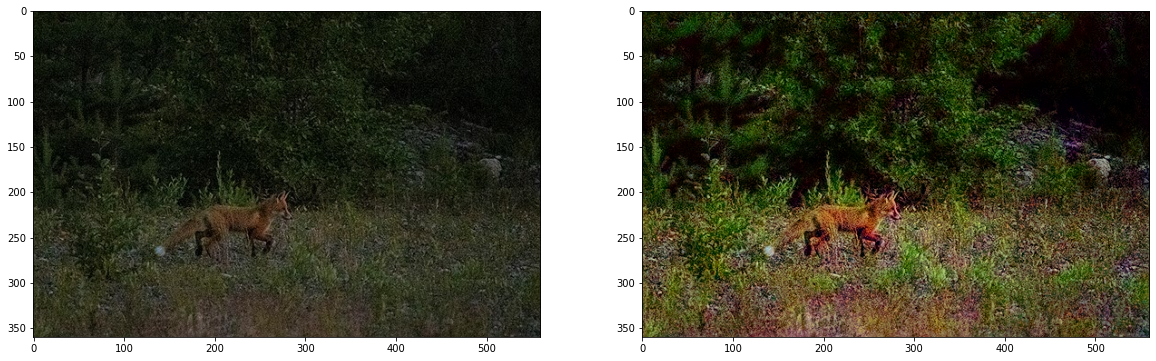

In [65]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import numpy as np
from PIL import Image
import sys

import torch
import torchvision.transforms.functional as TF

import requests
from io import BytesIO

from codes.utils import tensor2img

import matplotlib.pyplot as plt
%matplotlib inline


def load_image(path:str, mean:[float,tuple] = None, std:[float,tuple] = None):
    '''
    Load the image given a link or a path and convert it to Pytorch Image Tensor. Normalize only and only if any of the Mean or STD are given
    args:
      path: image link or path
      mean: Mean of the distribution from where it was taken or mean of the training set: could be a single number or a tuple of 3 numbers for each channel (r,g,b)
      std: Standard deviation of the distribution: could be a single number or a tuple of 3 numbers for each channel (r,g,b)

    returns:
      An image of dimensions (C,H,W) with range in [0-1] and dtype as float32
    '''

    if ("https" in path) or ("http" in path):
      image = Image.open(BytesIO(requests.get(path).content))

    else:
      image = Image.open(path)

    if image.mode != 'RGB':
      image = image.convert('RGB')
    
    # Check for the comments at line 45,46, 78 inside ./data/paired_image_dataset. They are using a 2 stage operation
    tensor_image = TF.to_tensor(image).to(DEVICE) # Originally they are using 1. utils.img_utils.imfrombytes  -> 2. utils.img_utils.img2tensor

    # taken from __getitem__() from the PairedImageDataset / UnPairedImageDataset Class defined in the module ./data/
    if mean is not None or std is not None:
            TF.normalize(tensor_image, mean, std, inplace=True)

    return tensor_image



url = "https://2.img-dpreview.com/files/p/TS560x560~forums/62902641/8ec07adb32b04f5dababb8f24bf10fb3"
torch_image = load_image(url)

with torch.no_grad():
  result = model(torch_image.unsqueeze(0)) 
  result = tensor2img(result.detach().cpu(), rgb2bgr = False)# Result if from -1 to 1. Need to rescale it from 0-1 or 0-255

f, ax = plt.subplots(1,2, figsize = (20,10))
ax[0].imshow(np.array(Image.open(BytesIO(requests.get(url).content))))
ax[1].imshow(result)